# **Libraries**

In [19]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import shutil

from google.colab import files
from keras_preprocessing import image
from shutil import copyfile
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# **Data Imports**

Source Dataset from Kaggle :

[Paddy Dataset 1](https://www.kaggle.com/competitions/paddy-disease-classification/data)

[Paddy Dataset 2](https://www.kaggle.com/datasets/badhon7432/paddyleafdiseaseuci)

In [2]:
! pip install kaggle

files.upload()

#create folder named kaggle
! mkdir ~/.kaggle

#copy kaggle.json into kaggle folder
! cp kaggle.json ~/.kaggle/

#chance permissions so that only you can read-write
! chmod 600 ~/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json


## **Downloading Dataset**

In [3]:
!kaggle competitions download -c paddy-disease-classification



 99% 1.01G/1.02G [00:11<00:00, 101MB/s]
100% 1.02G/1.02G [00:11<00:00, 97.6MB/s]


## **Unzipping Dataset**

In [4]:
file_zip = 'paddy-disease-classification.zip'
zip_ref = zipfile.ZipFile(file_zip, 'r')
zip_ref.extractall('/content/paddy-disease-classification/')
zip_ref.close()

print(os.listdir('/content/paddy-disease-classification/train_images'))

['downy_mildew', 'bacterial_leaf_streak', 'blast', 'hispa', 'normal', 'bacterial_leaf_blight', 'dead_heart', 'brown_spot', 'tungro', 'bacterial_panicle_blight']


# **Exploratory Data Analysis**

In [5]:
def move_image(src_dir, classname_list, destination_root_dir):
  """
  Params:
          src_dir: Root directory of source, enclosed by string
          classname_list : List contains desired name of class(es), ordered alphabetically
          destination_root_dir : Root directory of destination
  """ 
  if not os.path.exists(destination_root_dir):
    os.makedirs(destination_root_dir) 
  class_src = sorted([dirs for root, dirs, files in os.walk(src_dir)][0])
  for index in range(len(classname_list)):
    if os.path.exists(os.path.join(destination_root_dir, str(classname_list[index]))):
      os.makedirs(os.path.join(destination_root_dir, str(classname_list[index])))
    if len(class_src) == len(classname_list):
      shutil.copytree(os.path.join(src_dir, str(class_src[index])),
                      os.path.join(destination_root_dir, str(classname_list[index]))) 
    else:
      raise Exception("Number of directories not equal between source and destination")

In [6]:
paddyleaf_classname = ['Bacterial Leaf Blight',
                      'Bacterial Leaf Streak',
                      'Bacterial Panicle Blight',
                      'Blast',
                      'Brown Spot',
                      'Dead Heart',
                      'Down Mildew',
                      'Hispa',
                      'Normal',
                      'Tungro']

src_dir = ('/content/paddy-disease-classification/train_images')
root_dir = '/tmp/Data'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

move_image(src_dir, paddyleaf_classname, root_dir)

In [7]:
def simple_eda(data_dir):
  """
  Params:
              
  """ 
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  class_num = len(class_list)
  print("There are {} classes with various number of images for each".format(class_num))

  images_num = []
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    images_num.append(len(os.listdir(class_dir)))
    print("\n - {} : {} images".format(each_class, len(os.listdir(class_dir))))

  plt.figure(figsize=(8, 6))
  ax = plt.subplot()
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.bar(class_list, images_num, zorder=3)
  plt.grid(zorder=0)
  plt.title("Images Distribution", fontsize=20)
  plt.xlabel("Classes/Categories", fontsize=12)
  plt.show()

def display_sample(data_dir, num_sample):
  class_list = sorted([dirs for root, dirs, files in os.walk(data_dir)][0])
  for each_class in class_list:
    class_dir = os.path.join(data_dir, each_class)
    plt.figure(figsize=(100/num_sample, 4))
    print("\nLabel: {}".format(each_class))
    for index, image_path in enumerate(os.listdir(class_dir)[:num_sample]):
        ax = plt.subplot(1, num_sample, index+1)
        image = mpimg.imread(os.path.join(class_dir, image_path))
        ax.grid()
        plt.imshow(image)
    plt.show()

There are 10 classes with various number of images for each

 - Bacterial Leaf Blight : 479 images

 - Bacterial Leaf Streak : 380 images

 - Bacterial Panicle Blight : 337 images

 - Blast : 1738 images

 - Brown Spot : 965 images

 - Dead Heart : 1442 images

 - Down Mildew : 620 images

 - Hispa : 1594 images

 - Normal : 1764 images

 - Tungro : 1088 images


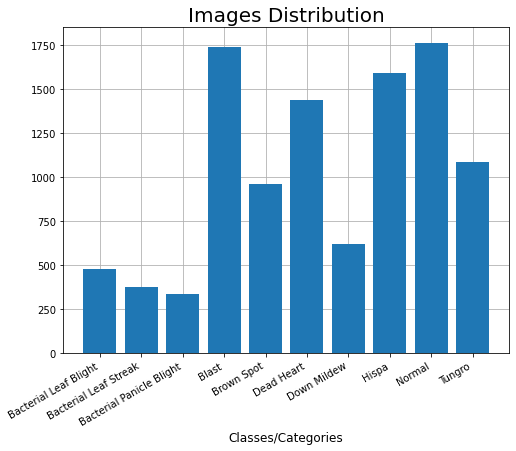

In [8]:
simple_eda(root_dir)


Label: Bacterial Leaf Blight


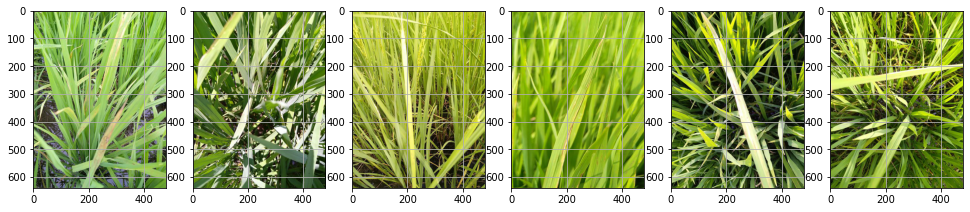


Label: Bacterial Leaf Streak


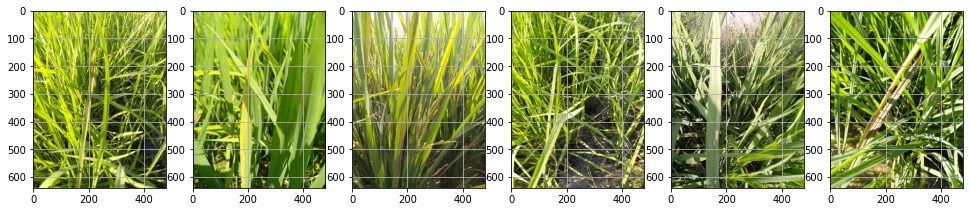


Label: Bacterial Panicle Blight


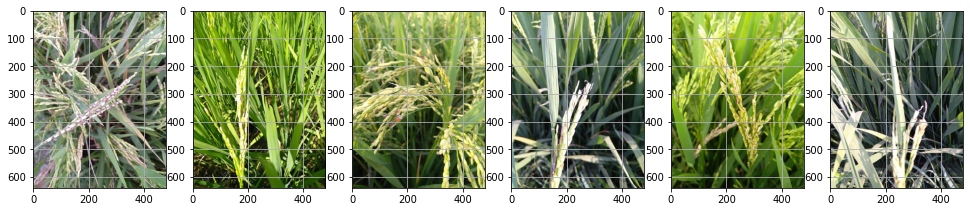


Label: Blast


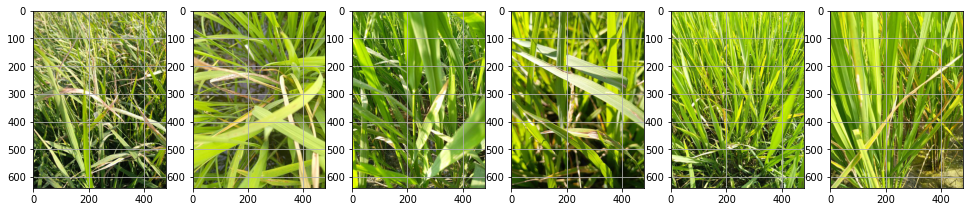


Label: Brown Spot


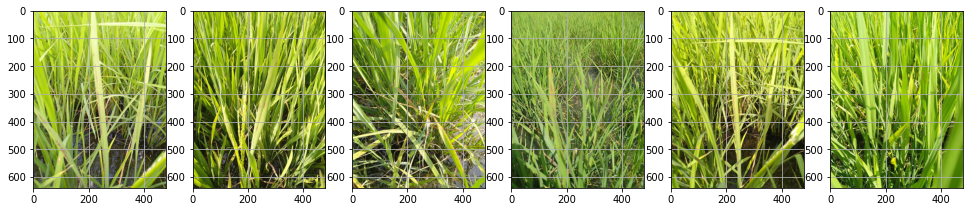


Label: Dead Heart


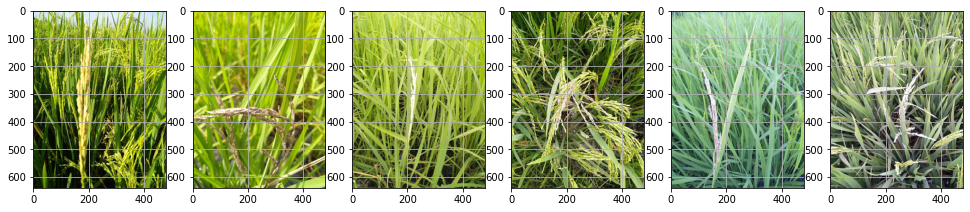


Label: Down Mildew


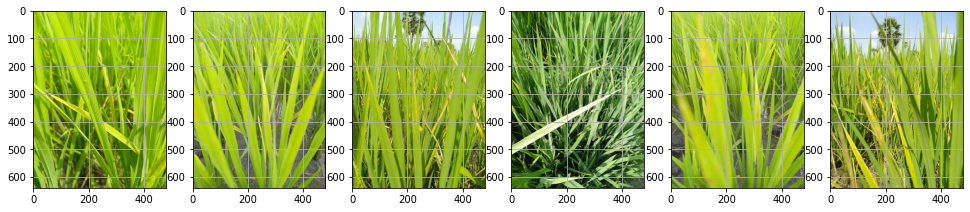


Label: Hispa


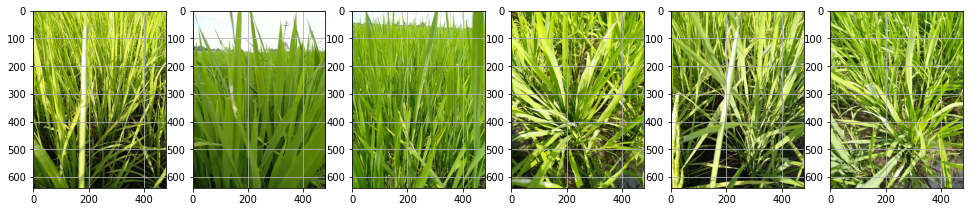


Label: Normal


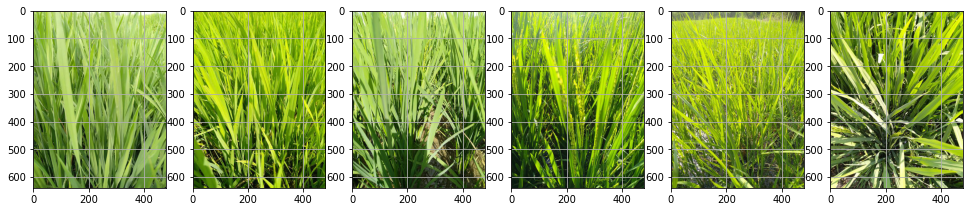


Label: Tungro


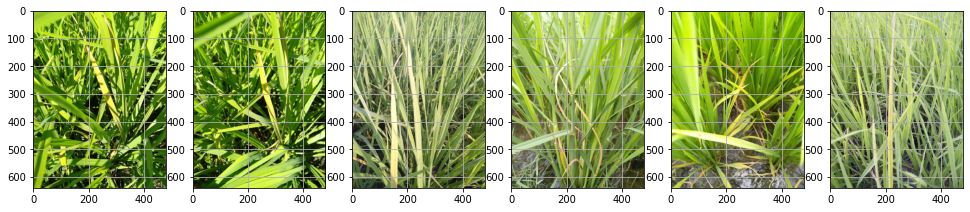

In [9]:
display_sample(root_dir, num_sample=6)

# **Split Dataset**

In [10]:
def split_class_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  """
  Params:
              
  """ 
  for dir in [TRAINING, VALIDATION, TESTING]:
    if not os.path.exists(dir):
      os.makedirs(dir)

  if SPLIT_SIZE > 1 or SPLIT_SIZE < 0:
    raise Exception('split size should be between 0 and 1')

  train_val_len = int(len(os.listdir(SOURCE)) * SPLIT_SIZE)
  for index, file in enumerate(os.listdir(SOURCE)): 
    if index < train_val_len:
      if index < int(.95 * train_val_len):
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TRAINING)))
      else:
        shutil.copy(os.path.join(SOURCE, file), os.path.join(str(VALIDATION)))
    else:
      shutil.copy(os.path.join(SOURCE, file), os.path.join(str(TESTING)))

def display_distribution(DIR, split_type=['Train', 'Validation', 'Test']):
  """
  Params:
                  
  """ 
  user_input_type = [split_type]
  type_list = ['Train', 'Validation', 'Test']
  if len(user_input_type) > 1:
    raise Exception("Please choose one type of split")
  if user_input_type[0] not in type_list:
    raise Exception("Please choose a type of split that provided; \'Train\', \'Validation\', or \'Test\'")
  
  print("\n{}".format(user_input_type[0]))
  for dir_class in sorted(os.listdir(DIR)):
    print('{}: {} images'.format(dir_class, len(os.listdir(os.path.join(DIR, dir_class)))))

In [11]:
root_split_dir = '/tmp/Split'

if os.path.exists(root_split_dir):
  shutil.rmtree(root_split_dir)

train_split_dir = os.path.join(root_split_dir, 'Train')
validation_split_dir = os.path.join(root_split_dir, 'Validation')
test_split_dir = os.path.join(root_split_dir, 'Test')

bacterial_leaf_blight_train_dir = os.path.join(train_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_train_dir = os.path.join(train_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_train_dir = os.path.join(train_split_dir, paddyleaf_classname[2])
blast_train_dir = os.path.join(train_split_dir, paddyleaf_classname[3])
brown_spot_train_dir = os.path.join(train_split_dir, paddyleaf_classname[4])
dead_heart_train_dir = os.path.join(train_split_dir, paddyleaf_classname[5])
downy_mildew_train_dir = os.path.join(train_split_dir, paddyleaf_classname[6])
hispa_train_dir = os.path.join(train_split_dir, paddyleaf_classname[7])
normal_train_dir = os.path.join(train_split_dir, paddyleaf_classname[8])
tungro_train_dir = os.path.join(train_split_dir, paddyleaf_classname[9])

bacterial_leaf_blight_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[2])
blast_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[3])
brown_spot_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[4])
dead_heart_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[5])
downy_mildew_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[6])
hispa_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[7])
normal_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[8])
tungro_validation_dir = os.path.join(validation_split_dir, paddyleaf_classname[9])

bacterial_leaf_blight_test_dir = os.path.join(test_split_dir, paddyleaf_classname[0])
bacterial_leaf_streak_test_dir = os.path.join(test_split_dir, paddyleaf_classname[1])
bacterial_panicle_blight_test_dir = os.path.join(test_split_dir, paddyleaf_classname[2])
blast_test_dir = os.path.join(test_split_dir, paddyleaf_classname[3])
brown_spot_test_dir = os.path.join(test_split_dir, paddyleaf_classname[4])
dead_heart_test_dir = os.path.join(test_split_dir, paddyleaf_classname[5])
downy_mildew_test_dir = os.path.join(test_split_dir, paddyleaf_classname[6])
hispa_test_dir = os.path.join(test_split_dir, paddyleaf_classname[7])
normal_test_dir = os.path.join(test_split_dir, paddyleaf_classname[8])
tungro_test_dir = os.path.join(test_split_dir, paddyleaf_classname[9])

bacterial_leaf_blight_source_dir = os.path.join(root_dir, paddyleaf_classname[0])
bacterial_leaf_streak_source_dir = os.path.join(root_dir, paddyleaf_classname[1])
bacterial_panicle_blight_source_dir = os.path.join(root_dir, paddyleaf_classname[2])
blast_source_dir = os.path.join(root_dir, paddyleaf_classname[3])
brown_spot_source_dir = os.path.join(root_dir, paddyleaf_classname[4])
dead_heart_source_dir = os.path.join(root_dir, paddyleaf_classname[5])
downy_mildew_source_dir = os.path.join(root_dir, paddyleaf_classname[6])
hispa_source_dir = os.path.join(root_dir, paddyleaf_classname[7])
normal_source_dir = os.path.join(root_dir, paddyleaf_classname[8])
tungro_source_dir = os.path.join(root_dir, paddyleaf_classname[9])

split_size = .999

split_class_data(bacterial_leaf_blight_source_dir, bacterial_leaf_blight_train_dir, bacterial_leaf_blight_validation_dir, bacterial_leaf_blight_test_dir, split_size)
split_class_data(bacterial_leaf_streak_source_dir, bacterial_leaf_streak_train_dir, bacterial_leaf_streak_validation_dir, bacterial_leaf_streak_test_dir, split_size)
split_class_data(bacterial_panicle_blight_source_dir, bacterial_panicle_blight_train_dir, bacterial_panicle_blight_validation_dir, bacterial_panicle_blight_test_dir, split_size)
split_class_data(blast_source_dir, blast_train_dir, blast_validation_dir, blast_test_dir, split_size)
split_class_data(brown_spot_source_dir, brown_spot_train_dir, brown_spot_validation_dir, brown_spot_test_dir, split_size)
split_class_data(dead_heart_source_dir, dead_heart_train_dir, dead_heart_validation_dir, dead_heart_test_dir, split_size)
split_class_data(downy_mildew_source_dir, downy_mildew_train_dir, downy_mildew_validation_dir, downy_mildew_test_dir, split_size)
split_class_data(hispa_source_dir, hispa_train_dir, hispa_validation_dir, hispa_test_dir, split_size)
split_class_data(normal_source_dir, normal_train_dir, normal_validation_dir, normal_test_dir, split_size)
split_class_data(tungro_source_dir, tungro_train_dir, tungro_validation_dir, tungro_test_dir, split_size)

print('[Split Distribution]')
display_distribution(train_split_dir, split_type='Train')
display_distribution(validation_split_dir, split_type='Validation')
display_distribution(test_split_dir, split_type='Test')

[Split Distribution]

Train
Bacterial Leaf Blight: 454 images
Bacterial Leaf Streak: 360 images
Bacterial Panicle Blight: 319 images
Blast: 1649 images
Brown Spot: 915 images
Dead Heart: 1368 images
Down Mildew: 588 images
Hispa: 1512 images
Normal: 1673 images
Tungro: 1031 images

Validation
Bacterial Leaf Blight: 24 images
Bacterial Leaf Streak: 19 images
Bacterial Panicle Blight: 17 images
Blast: 87 images
Brown Spot: 49 images
Dead Heart: 72 images
Down Mildew: 31 images
Hispa: 80 images
Normal: 89 images
Tungro: 55 images

Test
Bacterial Leaf Blight: 1 images
Bacterial Leaf Streak: 1 images
Bacterial Panicle Blight: 1 images
Blast: 2 images
Brown Spot: 1 images
Dead Heart: 2 images
Down Mildew: 1 images
Hispa: 2 images
Normal: 2 images
Tungro: 2 images


# **Image Augmentation**

In [12]:
def display_augmentation(IMG_PATH, ROTATION_RANGE, WIDTH_SHIFT_RANGE, 
                         HEIGHT_SHIFT_RANGE, SHEAR_RANGE, ZOOM_RANGE):
  """
  Params:
          
  """ 
  image = load_img(IMG_PATH)
  image_array = img_to_array(image)
  image_exp = np.expand_dims(image_array, 0)

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=ROTATION_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_rotate = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=WIDTH_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_width_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     height_shift_range=HEIGHT_SHIFT_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_height_shift = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     shear_range=SHEAR_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_shear = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=ZOOM_RANGE)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_zoom = batch[0]

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip=True)
  train_augment = train_datagen.flow(image_exp, batch_size=1)
  batch = train_augment.next()
  image_horizontal_flip = batch[0]

  fig = plt.figure(figsize=(10, 7))
  rows = 2
  cols = 4
  augmented_images = [0, image, image_rotate, image_width_shift, image_height_shift, image_shear, image_zoom, image_horizontal_flip]
  plt_title = [0, "Real Image", "Rotation", "Width Shift", "Height Shift", "Shear", "Zoom", "Horizontal Flip"]
  for index in range(len(augmented_images)):
    if index == 0:
      continue
    fig.add_subplot(rows, cols, index)
    plt.imshow(augmented_images[index])
    plt.axis('off')
    plt.title(plt_title[index])

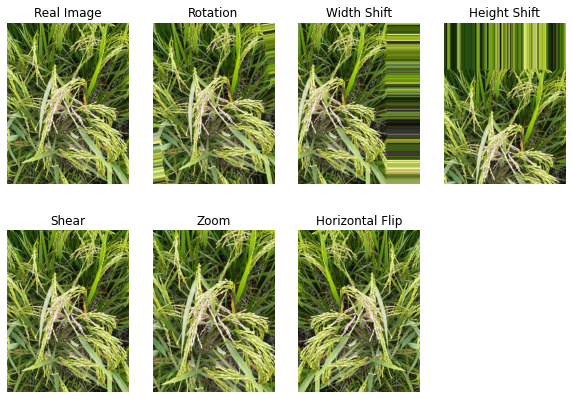

In [13]:
random_image = random.choice(os.listdir(dead_heart_train_dir))
rotation_range = 40
width_shift_range = .3
height_shift_range = .3
shear_range = .4
zoom_range = .2
display_augmentation(os.path.join(dead_heart_train_dir, random_image),
                     rotation_range,
                     width_shift_range,
                     height_shift_range,
                     shear_range,
                     zoom_range)

In [14]:
def train_val_generator(TRAINING_DIR, VALIDATION_DIR, 
                         TARGET_SIZE, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE):
  """
  Params:
          
  Returns:

  """ 
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=90,
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     shear_range=.2,
                                     zoom_range=.2,
                                     horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=TRAIN_BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=TARGET_SIZE)


  validation_datagen = ImageDataGenerator(rescale=1./255)

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=VAL_BATCH_SIZE,
                                                                class_mode='categorical',
                                                                target_size=TARGET_SIZE)
  return train_generator, validation_generator

In [15]:
train_batch_size = 32
val_batch_size = 20
target_size = (150, 150)

train_generator, validation_generator = train_val_generator(train_split_dir,
                                                            validation_split_dir,
                                                            target_size,
                                                            train_batch_size,
                                                            val_batch_size)

Found 9869 images belonging to 10 classes.
Found 523 images belonging to 10 classes.


In [16]:
print("Train Generator code for each class \n{}".format(train_generator.class_indices))
print("\n Validation Generator code for each class \n{}".format(validation_generator.class_indices))

Train Generator code for each class 
{'Bacterial Leaf Blight': 0, 'Bacterial Leaf Streak': 1, 'Bacterial Panicle Blight': 2, 'Blast': 3, 'Brown Spot': 4, 'Dead Heart': 5, 'Down Mildew': 6, 'Hispa': 7, 'Normal': 8, 'Tungro': 9}

 Validation Generator code for each class 
{'Bacterial Leaf Blight': 0, 'Bacterial Leaf Streak': 1, 'Bacterial Panicle Blight': 2, 'Blast': 3, 'Brown Spot': 4, 'Dead Heart': 5, 'Down Mildew': 6, 'Hispa': 7, 'Normal': 8, 'Tungro': 9}


# **Architeture Model**

In [17]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_split_dir,
    batch_size=11,
    class_mode = 'binary',
    target_size = (300, 300),
    shuffle=True
)



validation_datagen = ImageDataGenerator(
    rescale = 1/255
)

validation_generator = validation_datagen.flow_from_directory(
    validation_split_dir,
    batch_size=4,
    class_mode = 'binary',
    target_size = (300, 300),
    shuffle=True
)

Found 9869 images belonging to 10 classes.
Found 523 images belonging to 10 classes.


In [24]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 64)      

In [26]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    verbose = 1)

Epoch 1/20
898/898 [==============================] - 1198s 1s/step - loss: 0.0000e+00 - accuracy: 0.0365 - val_loss: 0.0000e+00 - val_accuracy: 0.0363
Epoch 2/20
898/898 [==============================] - 1161s 1s/step - loss: 0.0000e+00 - accuracy: 0.0365 - val_loss: 0.0000e+00 - val_accuracy: 0.0363
Epoch 3/20
898/898 [==============================] - 1155s 1s/step - loss: 0.0000e+00 - accuracy: 0.0365 - val_loss: 0.0000e+00 - val_accuracy: 0.0363
Epoch 4/20
229/898 [======>.......................] - ETA: 14:07 - loss: 0.0000e+00 - accuracy: 0.0335

KeyboardInterrupt: ignored